In [1]:
!pip install -U scikit-learn

     |████████████████████████████████| 22.3MB 119kB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [2]:
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from joblib import dump

In [3]:
sklearn.__version__

'0.24.1'

In [4]:
!cp /content/drive/MyDrive/ExpertSystem/cleaned_abusive_nonabusive.csv  /content/

In [5]:
data = pd.read_csv("/content/cleaned_abusive_nonabusive.csv")

In [6]:
data.head()

,text,label
0,Bailey has gone for a sleep over I feel crap i...,0
1,"""\n \nCustom500\n\nIts my user page, ill edit ...",0
2,"It seems to me that when creating this page, s...",0
3,Bring my nigga Nip back!,0
4,Still you havent explained why it is a POV and...,0


In [7]:
count_not_abusive = 0
count_abusive = 0
for i in data.label:
  if i == 0:
    count_not_abusive += 1
  else:
    count_abusive += 1

print("Non Abusive: {}".format(count_not_abusive))
print("Abusive: {}".format(count_abusive))

Non Abusive: 205399
Abusive: 151640


In [8]:
texts = data["text"].astype(str)
y = data["label"]

In [9]:
abusive = []
for i in range(len(data['label'])):
  if data['label'][i] == 1:
    abusive.append(data['text'][i])

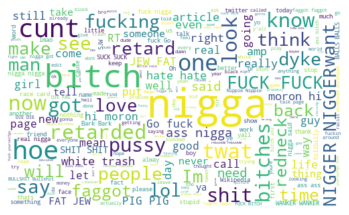

In [10]:
word_text = " ".join(map(str, abusive))
wordcloud = WordCloud(max_font_size=60, max_words=250, background_color="white", width=500, height=300).generate(word_text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
vectorizer = TfidfVectorizer(stop_words="english", min_df=0.0001)
X = vectorizer.fit_transform(texts)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)

# Random Forest

In [14]:
rf = RandomForestClassifier(max_depth=100, random_state=0)

In [15]:
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=100, random_state=0)

In [16]:
rf_y_hat = rf.predict(X_test)
accuracy_score(rf_y_hat, y_test) 

0.7967874747927403

In [17]:
rf_score = accuracy_score(rf_y_hat, y_test) 

# Calibrated Classifier

In [18]:
model = LinearSVC(class_weight="balanced", dual=False, tol=1e-2, max_iter=1e5)
cclf = CalibratedClassifierCV(base_estimator=model)
cclf.fit(X_train, y_train)

CalibratedClassifierCV(base_estimator=LinearSVC(class_weight='balanced',
                                                dual=False, max_iter=100000.0,
                                                tol=0.01))

In [19]:
y_hat = cclf.predict(X_test)
cc_score = accuracy_score(y_hat, y_test) 
print(cc_score)

0.7992661886623348


# Decision Tree

In [20]:
dt = DecisionTreeClassifier(random_state=0)

In [21]:
dt.fit(X_train, y_train)

DecisionTreeClassifier(random_state=0)

In [22]:
dt_y_hat = dt.predict(X_test)
dt_score = accuracy_score(dt_y_hat, y_test)
print(dt_score)

0.7909197848980506


# Plot

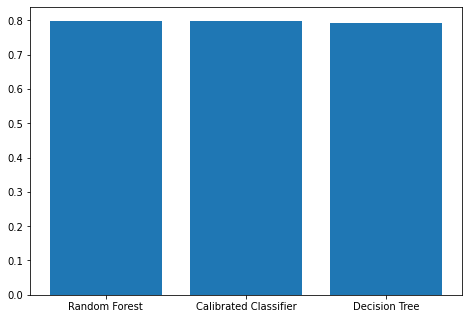

In [23]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
classifiers = ['Random Forest', 'Calibrated Classifier', 'Decision Tree']
acc = [rf_score, cc_score, dt_score]
ax.bar(classifiers,acc)
plt.show()

# Train on Whole Set

In [24]:
model = LinearSVC(class_weight="balanced", dual=False, tol=1e-2, max_iter=1e5)
best_cclf = CalibratedClassifierCV(base_estimator=model)
best_cclf.fit(X, y)

CalibratedClassifierCV(base_estimator=LinearSVC(class_weight='balanced',
                                                dual=False, max_iter=100000.0,
                                                tol=0.01))

# Save Model

In [25]:
dump(vectorizer, "updated_vectorizer.joblib")
dump(best_cclf, "updated_bestmodel.joblib")

['updated_bestmodel.joblib']

In [26]:
!cp /content/updated_bestmodel.joblib  /content/drive/MyDrive/ExpertSystem/

In [27]:
!cp /content/updated_vectorizer.joblib  /content/drive/MyDrive/ExpertSystem/

# Test

In [28]:
test_str = "These Pies are fucking piece of shit"

In [29]:
test_x=vectorizer.transform([test_str])

In [30]:
best_cclf.predict(test_x)

array([1])

In [31]:
best_cclf.predict_proba(test_x)

array([[0.08298947, 0.91701053]])

In [32]:
np.max(best_cclf.predict_proba(test_x))*100

91.70105333467218

In [33]:
labels = ['Non Abusive', 'Abusive']

In [34]:
print("Tone: {}, Probability Score: {:.2f}%".format(labels[best_cclf.predict(test_x)[0]], (np.max(best_cclf.predict_proba(test_x))*100))) 

Tone: Abusive, Probability Score: 91.70%
